<a href="https://colab.research.google.com/github/Jtouloupis/CovidTweetsAnalyser/blob/main/Copy_of_TweetAnalyserV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.4 MB/s eta 0:00:00


In [ ]:
import nltk
import re
import string
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import random

#BERT
import torch
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

print('Done')


Done


In [ ]:
data = pd.read_csv('/content/tweets.csv',encoding='latin-1',header=0)


In [ ]:
# Shuffle the rows using the sample function
df_shuffled = data.sample(frac=1)

# Reset the index of the shuffled DataFrame
data = df_shuffled.reset_index(drop=True)

In [ ]:
data.describe()

,Type
count,3099.000000
mean,0.896418
std,0.817369
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [ ]:
#Is there any other different value than neutral, negative and positive?
data['Type'].unique()

array([2, 0, 1])

In [ ]:
#How's distributed the dataset? Is it biased?
data.groupby('Type').nunique()

,Tweets,Url
Type,,
0,1188,896
1,974,676
2,889,240


In [ ]:
#Let's keep only the columns that we're going to use
data = data[['Tweets','Type']]
data.head()


,Tweets,Type
0,3 month since I got covid update \n\nSymptoms ...,2
1,"As we celebrate summer get togethers, such as ...",0
2,Total BS. It's now proven... no one has natura...,0
3,@debzc1 They don't want to debate their compli...,1
4,FDA updates all opioid medication labeling and...,2


In [ ]:
#Is there any null value?
data["Tweets"].isnull().sum()

0

In [ ]:
#Let's fill the only null value.
data["Tweets"].fillna("No content", inplace = True)

In [ ]:
print(data)

                                                 Tweets  Type
0     3 month since I got covid update \n\nSymptoms ...     2
1     As we celebrate summer get togethers, such as ...     0
2     Total BS. It's now proven... no one has natura...     0
3     @debzc1 They don't want to debate their compli...     1
4     FDA updates all opioid medication labeling and...     2
...                                                 ...   ...
3094  Yes. Been going on for decades but got a huge ...     1
3095  Thread\nSee new Tweets\nConversation\nVirtual ...     2
3096  OK update just out UK NHS Covid news\nSpring C...     2
3097  Mom and I got our second boosters today at the...     0
3098  @sfchronicle This is why we need to #KeepMasks...     0

[3099 rows x 2 columns]


In [ ]:
def depure_data(data):

    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

    return data

In [ ]:
# Step 1: Load and preprocess the CSV file
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }



In [ ]:
# Step 2: Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
texts = data["Tweets"].tolist()
labels = data['Type'].tolist()

In [ ]:
# Step 3: Load and preprocess the CSV file
dataset = CustomDataset(texts, labels, tokenizer, max_length=128)


In [ ]:


batch_size = 4
train_size = int(0.85 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Freeze some layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False


In [ ]:
# Step 5: Fine-tune the BERT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate accuracy and average loss for the epoch
    accuracy = correct_predictions / total_predictions
    average_loss = total_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Training Accuracy: {accuracy:.4f}")
    print(f"  Training Average Loss: {average_loss:.4f}")

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # Add the 'labels' argument
            loss = outputs.loss
            total_loss += loss.item()

            _, predicted_labels = torch.max(outputs.logits, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

        accuracy = correct_predictions / total_predictions
        average_loss = total_loss / len(test_dataloader)

        print(f"  Testing Accuracy: {accuracy:.4f}")
        print(f"  Testing Average Loss: {average_loss:.4f}")

# Step 6: Use the fine-tuned model to make predictions
model.eval()




# Save the model's state_dict to a file
torch.save(model.state_dict(), 'bert_sentiment_model.pth')

Epoch 1/4:
  Training Accuracy: 0.7612
  Training Average Loss: 0.5490
  Testing Accuracy: 0.8258
  Testing Average Loss: 0.4179
Epoch 2/4:
  Training Accuracy: 0.9077
  Training Average Loss: 0.2502
  Testing Accuracy: 0.8667
  Testing Average Loss: 0.3359
Epoch 3/4:
  Training Accuracy: 0.9647
  Training Average Loss: 0.1135
  Testing Accuracy: 0.8452
  Testing Average Loss: 0.4827
Epoch 4/4:
  Training Accuracy: 0.9810
  Training Average Loss: 0.0641
  Testing Accuracy: 0.8215
  Testing Average Loss: 0.5776


In [ ]:
# Load the saved model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load('bert_sentiment_model.pth'))
model.to(device)
model.eval()

# Function to make predictions on new texts
def predict_sentiment(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_tensors='pt',
        truncation=True
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted_label = torch.max(logits, 1)

    return predicted_label.item()

# Example usage:
text1 = "covid vaccine protected my elder family"
text2 = "injuries are happening but they are not many in comparison with the long covid cases"
text3 = "covid is a created virus that is going to controll us"
text4 = "just wear a mask an protect the others"
text5 = "On 21 February 2021 I noted in an affidavit that the World Health Organisation had 102,000 reports of COVID vaccine adverse drug reactions on its http://vigiaccess.org database. This week the number passed the 5,000,000 mark.  Let me repeat this because it is hard to believe. According to WHO’s own data, more than 5,000,000 people are suspected to have been harmed by the COVID vaccines. The exact number today is 5,026,245 people, including tens of thousands of deaths."
test6 ="injecting children with an experimental gene therapy, silencing critics, and mask mandates. In addition, you have pronouns in your bio and called the Covid vaccines 'safe and effective'.You should keep your mouth shut!"

prediction1 = predict_sentiment(text1) #0
prediction2 = predict_sentiment(text2) #2
prediction3 = predict_sentiment(text3) #1
prediction4 = predict_sentiment(text4) #0
prediction5 = predict_sentiment(text5) #1
prediction6 = predict_sentiment(text5) #1
p7 = predict_sentiment("The Bible has been manipulated by the dark side for a long time. The real bible was found under the Vatican. This guy has many different bibles and shows you the difference in regards to the Mark of the Beast ! COVID SHOT") #1
p8 = predict_sentiment("Getting Covid is not a personal failing Getting long Covid is not a personal failing Being high risk for Covid is not a personal failing People have about as much control over this as their eye colour.So stop treating all of the above like it’s their fault") #0 / 2
p9 = predict_sentiment("Our Covid data project Is over, but the need for timely data is not.The John Hopkins Coronavirus Resource Centre.") #2
p10 = predict_sentiment("5000 are the new covid cases in greece for the week")#2

print("Prediction 1:", prediction1)
print("Prediction 2:", prediction2)
print("Prediction 3:", prediction3)
print("Prediction 4:", prediction4)
print("Prediction 5:", prediction5)
print("Prediction 6:", prediction6)
print("Prediction 7:", p7)
print("Prediction 8:", p8)
print("Prediction 9:", p9)
print("Prediction 9:", p10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction 1: 0
Prediction 2: 1
Prediction 3: 1
Prediction 4: 0
Prediction 5: 1
Prediction 6: 1
Prediction 7: 1
Prediction 8: 0
Prediction 9: 1
Prediction 9: 2


In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = data['Tweets'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:10])

['3 month since I got covid update Symptoms that have passed: - Congestion - Coughing - Burning Skin - Constantly overheating - Suppressed appetite - Dizziness - Extremely light sleep - Confusion/disorientation - Inability to visualize - Derealisation - Extreme ',
 'As we celebrate summer get togethers, such as family reunions, graduations and vacations... please be safe. #Vaccinatedandboosted',
 'Total BS. Its now proven... no one has natural immunity. Many covid-19 patients caught it more than once and get hospitalized. And its already proven in US with >620K deaths - path via natural immunity will be a disaster - with lots of people to die along the way. If it wasnt for the vaccine US probably wouldve added at least another 300K deaths more to what we already have.',
 'They dont want to debate their complicity in the #scamdemic #democide #humanrightsabuses',
 'FDA updates all opioid medication labeling and includes a warning about OIH.',
 'COVID vaccines for Americas youngest youngs

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


data_words = list(sent_to_words(temp))

print(data_words[:5])

[['month', 'since', 'got', 'covid', 'update', 'symptoms', 'that', 'have', 'passed', 'congestion', 'coughing', 'burning', 'skin', 'constantly', 'overheating', 'suppressed', 'appetite', 'dizziness', 'extremely', 'light', 'sleep', 'confusion', 'disorientation', 'inability', 'to', 'visualize', 'derealisation', 'extreme'], ['as', 'we', 'celebrate', 'summer', 'get', 'togethers', 'such', 'as', 'family', 'reunions', 'graduations', 'and', 'vacations', 'please', 'be', 'safe'], ['total', 'bs', 'its', 'now', 'proven', 'no', 'one', 'has', 'natural', 'immunity', 'many', 'covid', 'patients', 'caught', 'it', 'more', 'than', 'once', 'and', 'get', 'hospitalized', 'and', 'its', 'already', 'proven', 'in', 'us', 'with', 'deaths', 'path', 'via', 'natural', 'immunity', 'will', 'be', 'disaster', 'with', 'lots', 'of', 'people', 'to', 'die', 'along', 'the', 'way', 'if', 'it', 'wasnt', 'for', 'the', 'vaccine', 'us', 'probably', 'wouldve', 'added', 'at', 'least', 'another', 'deaths', 'more', 'to', 'what', 'we', '

In [ ]:
len(data_words)


3099

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data2 = []
for i in range(len(data_words)):
    data2.append(detokenize(data_words[i]))
print(data2[:5])

['month since got covid update symptoms that have passed congestion coughing burning skin constantly overheating suppressed appetite dizziness extremely light sleep confusion disorientation inability to visualize derealisation extreme', 'as we celebrate summer get togethers such as family reunions graduations and vacations please be safe', 'total bs its now proven no one has natural immunity many covid patients caught it more than once and get hospitalized and its already proven in us with deaths path via natural immunity will be disaster with lots of people to die along the way if it wasnt for the vaccine us probably wouldve added at least another deaths more to what we already have', 'they dont want to debate their complicity in the scamdemic democide', 'fda updates all opioid medication labeling and includes warning about oih']


In [ ]:
#data2['Type'].unique()

In [ ]:
labels = np.array(data['Type'])
labels = tf.keras.utils.to_categorical(labels, 3, dtype="float32")

In [ ]:
print(labels)


[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
data2 = np.array(data2)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data2)
sequences = tokenizer.texts_to_sequences(data2)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)


[[   0    0    0 ... 4259 4260 2912]
 [   0    0    0 ...  141   19  135]
 [   0    0    0 ...   18  348   21]
 ...
 [   0    0    0 ...   11  532 1066]
 [   0    0    0 ...   69 4158   37]
 [   0    0    0 ...   18   76    2]]


In [ ]:
print(labels)


[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
##from keras.layers import Embedding
#embedding_layer = Embedding(1000, 64)

In [ ]:
#Splitting the data
#X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
X_train = tweets[0:2000]
y_train = labels[0:2000]
X_test =  tweets[2000:2508]
y_test = labels[2000:2508]


print (len(X_train),len(X_test),len(y_train),len(y_test))

2000 508 2000 508


In [ ]:
model2 = Sequential()
#model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Embedding(5000, 32, input_length=200))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=25,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 1.0821 - accuracy: 0.3915
Epoch 1: val_accuracy improved from -inf to 0.38583, saving model to best_model2.hdf5
63/63 [==============================] - 17s 167ms/step - loss: 1.0821 - accuracy: 0.3915 - val_loss: 1.0591 - val_accuracy: 0.3858
Epoch 2/25
63/63 [==============================] - ETA: 0s - loss: 0.9938 - accuracy: 0.5020
Epoch 2: val_accuracy improved from 0.38583 to 0.49016, saving model to best_model2.hdf5
63/63 [==============================] - 7s 106ms/step - loss: 0.9938 - accuracy: 0.5020 - val_loss: 0.9256 - val_accuracy: 0.4902
Epoch 3/25
63/63 [==============================] - ETA: 0s - loss: 0.8206 - accuracy: 0.6040
Epoch 3: val_accuracy improved from 0.49016 to 0.60827, saving model to best_model2.hdf5
63/63 [==============================] - 5s 84ms/step - loss: 0.8206 - accuracy: 0.6040 - val_loss: 0.7961 - val_accuracy: 0.6083
Epoch 4/25
63/63 [==============================] - ETA: 0s -

In [ ]:
predictions = model2.predict(X_test)


16/16 [==============================] - 1s 6ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<Axes: >

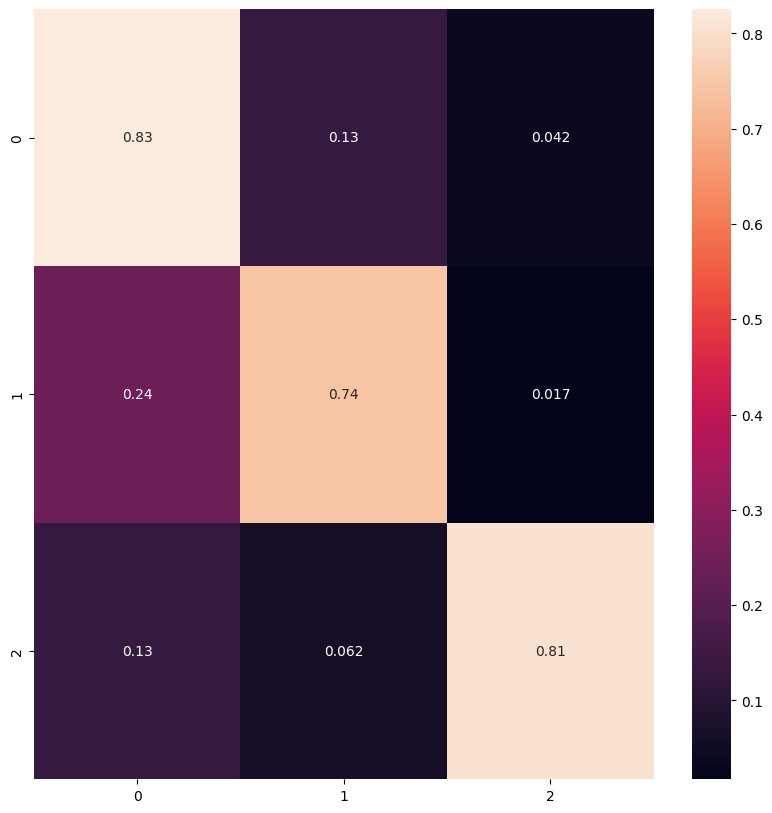

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['0','1','2'],columns = ['0','1','2'])
#Normalizing
conf_matrix = conf_matrix.astype('int') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 10})

In [ ]:
sentiment = ['0','1','2']


In [ ]:
sequence = tokenizer.texts_to_sequences(["5000 are the new covid cases in greece for the week"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 26ms/step


'0'

In [ ]:
sequence = tokenizer.texts_to_sequences(["vaccine injuries are happening"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 25ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["injuries are happening but they are not many in comparison with the long covid cases"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 29ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["20 vaccine injuries and 1000 long covid patients were recorded for this month"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 25ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(['the covid vaccine protected my two sons'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 24ms/step


'0'

In [ ]:
sequence = tokenizer.texts_to_sequences(["just wear a mask an protect the others"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 24ms/step


'0'

In [ ]:
sequence = tokenizer.texts_to_sequences(["covid is a created virus that is going to controll us"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 27ms/step


'0'

In [ ]:
sequence = tokenizer.texts_to_sequences(["covid-19 is a bio weapon leaked from a lab"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 27ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["Suzanne Gazda MD is a neurologist with 4,000 patients. The vast majority were advised to take the vaccine by other doctors. The vast majority of those got significantly worse after they took the COVID vaccine."])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 23ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["covid-19 does not exist"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 24ms/step


'1'

In [ ]:

sequence = tokenizer.texts_to_sequences(["54 year old Canadian doctor Dr.Annie Rousseau died on April 21, 2023She was an internist & gastroenterologist in Saint-Jean-sur-Richelieu, Quebec.Fully COVID-19 mRNA vaccinated. Dead at 54.@CMA_Docsneeds to be sued by families of all dead MDs"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 25ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["My daughter has 3 more days of being a high school senior, 3 more days in an N99 in open air classrooms. Then shes on to online courses after graduation ceremony in June…shes 15 AND she wrote a book and watched family disappear due to her covid stance. Round of applause is ok."])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 26ms/step


'2'

In [ ]:
sequence = tokenizer.texts_to_sequences(["On 21 February 2021 I noted in an affidavit that the World Health Organisation had 102,000 reports of COVID vaccine adverse drug reactions on its http://vigiaccess.org database. This week the number passed the 5,000,000 mark.  Let me repeat this because it is hard to believe. According to WHO’s own data, more than 5,000,000 people are suspected to have been harmed by the COVID vaccines. The exact number today is 5,026,245 people, including tens of thousands of deaths."])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]
#wrong

1/1 [==============================] - 0s 25ms/step


'0'

In [ ]:
sequence = tokenizer.texts_to_sequences(["My gawd 😭 I can’t believe they did this to people at funerals. NEVER FORGET how people were treating during “covid”Just found this post and it so heartbreaking"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 26ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["@RobertKennedyJrcalls out Bill Gates and the World Economic Forum saying they are exploiting climate change like they exploited Covid"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]   #wrong?

1/1 [==============================] - 0s 44ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["Excuse me, Sir, but you've been in favor of lockdowns, injecting children with an experimental gene therapy, silencing critics, and mask mandates. In addition, you have pronouns in your bio and called the Covid vaccines 'safe and effective'.You should keep your mouth shut!"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 53ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["The Bible has been manipulated by the dark side for a long time. The real bible was found under the Vatican. This guy has many different bibles and shows you the difference in regards to the Mark of the Beast ! COVID SHOT"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 44ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["Getting Covid is not a personal failing Getting long Covid is not a personal failing Being high risk for Covid is not a personal failing People have about as much control over this as their eye colour.So stop treating all of the above like it’s their fault"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 35ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["It's alright.The pandemic is over.People stopped dying of Covid when we stopped testing for Covid.And now they just die 'deaths not involving Covid' during waves of Covid."])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]
#wrong

1/1 [==============================] - 0s 35ms/step


'1'

In [ ]:
sequence = tokenizer.texts_to_sequences(["Our Covid data project Is over, but the need for timely data is not.The John Hopkins Coronavirus Resource Centre."])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 37ms/step


'2'